In [1]:
import pymysql.cursors
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.ticker as mticker

# Connect to the database
connection = pymysql.connect(host='localhost',
                             user='root',
                             password='root',
                             db='tv4e',
                             charset='latin1',
                             cursorclass=pymysql.cursors.DictCursor)
connection

In [2]:
query = "SELECT r.*, v.duration, u.name FROM majordomo_rating r, majordomo_video v, majordomo_user u WHERE  r.video_id=v.id AND r.user_id = u.id AND NOT ((r.watched_type = 'forced' OR r.watched_type = 'mobile' OR user_id IN (1, 2, 3, 21, 9)))"
df_ratings = pd.read_sql(query, connection)

df_ratings.set_index('id', inplace=True)
df_ratings = df_ratings[df_ratings.watched_type != 'forced']

df_ratings.head()

,watch_time,date_creation,watched_type,rating_implicit,rating_explicit,overall_rating_value,user_id,video_id,duration,name
id,,,,,,,,,,
22394,100,2018-01-20 22:07:39,injected,1.0,1.0,1.0,4,5363,209,Teresa Rei
22395,100,2018-01-20 13:44:41,injected,1.0,NaN,0.5,4,5385,123,Teresa Rei
22396,100,2018-01-20 21:37:39,injected,1.0,NaN,0.5,4,5393,308,Teresa Rei
22397,100,2018-01-20 17:44:46,injected,1.0,NaN,0.5,4,5423,335,Teresa Rei
22398,100,2018-01-20 15:14:35,injected,1.0,0.0,0.3,4,5427,120,Teresa Rei


In [3]:
df_ratings.describe()

,watch_time,rating_implicit,rating_explicit,overall_rating_value,user_id,video_id,duration
count,539.000000,539.000000,274.000000,539.000000,539.000000,539.000000,539.000000
mean,93.372913,0.933729,0.142336,0.399314,32.031540,5739.417440,149.200371
std,22.616244,0.226162,0.539464,0.366266,8.778402,221.153797,83.128314
min,1.000000,0.010000,-1.000000,-1.000000,4.000000,5363.000000,19.000000
25%,100.000000,1.000000,0.000000,0.300000,31.000000,5586.000000,97.000000
50%,100.000000,1.000000,0.000000,0.500000,34.000000,5712.000000,140.000000
75%,100.000000,1.000000,0.000000,0.500000,37.000000,5831.000000,191.000000
max,100.000000,1.000000,1.000000,1.000000,42.000000,6357.000000,453.000000


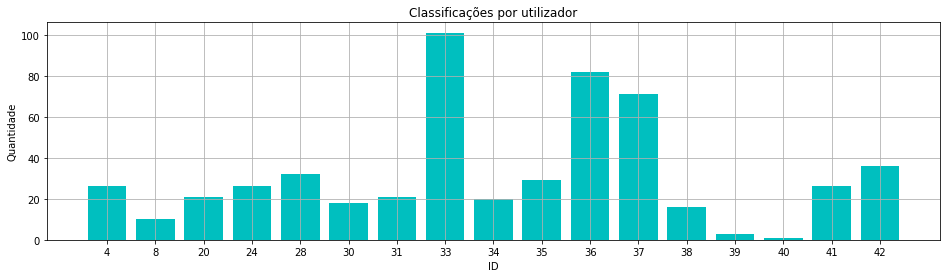

Número de classificações: 539
Número de utilizadores: 17
Média de vídeos vistos por utilizador: 32


In [4]:
# Grouping ratings by user
df_ratings_by_user = df_ratings.groupby(['user_id']).size().reset_index(name='counts')
id = df_ratings_by_user.user_id.unique().astype(str)

plt.clf()
fig = plt.figure(figsize=(16,4))

plt.title('Classificações por utilizador')
plt.bar(range(len(id)), df_ratings_by_user.counts, color='c', width=0.8)
plt.ylabel('Quantidade')
plt.xlabel('ID')

plt.xticks(range(len(id)),id)

plt.grid(True)
plt.show()

number_of_ratings = df_ratings.shape[0]
number_of_users = len(id)
print("Número de classificações: {}".format(number_of_ratings))
print("Número de utilizadores: {}".format(number_of_users))
print("Média de vídeos vistos por utilizador: {0:.0f}".format(number_of_ratings/number_of_users))

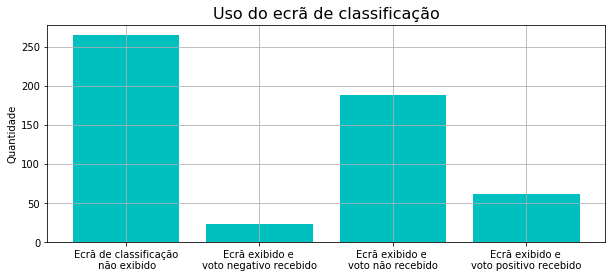

In [5]:
# Checking ratings distribution
df_ratings_distribution = df_ratings.fillna(-2) # using -2 to represent the scenario where no rating screen was shown
df_ratings_distribution = df_ratings_distribution.groupby(['rating_explicit']).size().reset_index(name='counts')


plt.clf()
fig = plt.figure(figsize=(10,4))
plt.title('Uso do ecrã de classificação', fontsize=16)
plt.bar(range(len(df_ratings_distribution.rating_explicit)), df_ratings_distribution.counts, color='c', width=0.8)
plt.ylabel('Quantidade')


labels = ['Ecrã de classificação\n não exibido',
          'Ecrã exibido e \nvoto negativo recebido', 
          'Ecrã exibido e \nvoto não recebido',
          'Ecrã exibido e \nvoto positivo recebido']

plt.xticks(range(len(df_ratings_distribution.rating_explicit)), labels)

plt.grid(True)
plt.show()

In [6]:
# Checking algoritmh precision

df_precision = df_ratings.dropna()

positive_votes = df_precision[df_precision['rating_explicit'] ==  1].shape[0]
negative_votes = df_precision[df_precision['rating_explicit'] == -1].shape[0]
neutral_votes = df_precision[df_precision['rating_explicit'] == 0].shape[0]
all_votes = df_precision.shape[0]

precision = positive_votes/(positive_votes+negative_votes)
print("Precisão do algoritmo: {0:.2f}%". format(precision*100))
print("Votos positivos: {0}". format(positive_votes))
print("Votos negativos: {0}". format(negative_votes))
print("Votos neutros: {0}". format(neutral_votes))

Precisão do algoritmo: 72.94%
Votos positivos: 62
Votos negativos: 23
Votos neutros: 189


In [7]:
# Checking features correlations
# Use dummies of watched type to check corr between ratings and types
df_ratings.corr()

,watch_time,rating_implicit,rating_explicit,overall_rating_value,user_id,video_id,duration
watch_time,1.000000,1.000000,0.016040,0.247171,-0.017595,-0.129209,-0.006099
rating_implicit,1.000000,1.000000,0.016040,0.247171,-0.017595,-0.129209,-0.006099
rating_explicit,0.016040,0.016040,1.000000,0.961106,-0.302214,-0.155027,-0.006227
overall_rating_value,0.247171,0.247171,0.961106,1.000000,-0.186246,-0.145545,-0.013088
user_id,-0.017595,-0.017595,-0.302214,-0.186246,1.000000,0.687001,-0.148904
video_id,-0.129209,-0.129209,-0.155027,-0.145545,0.687001,1.000000,-0.228775
duration,-0.006099,-0.006099,-0.006227,-0.013088,-0.148904,-0.228775,1.000000


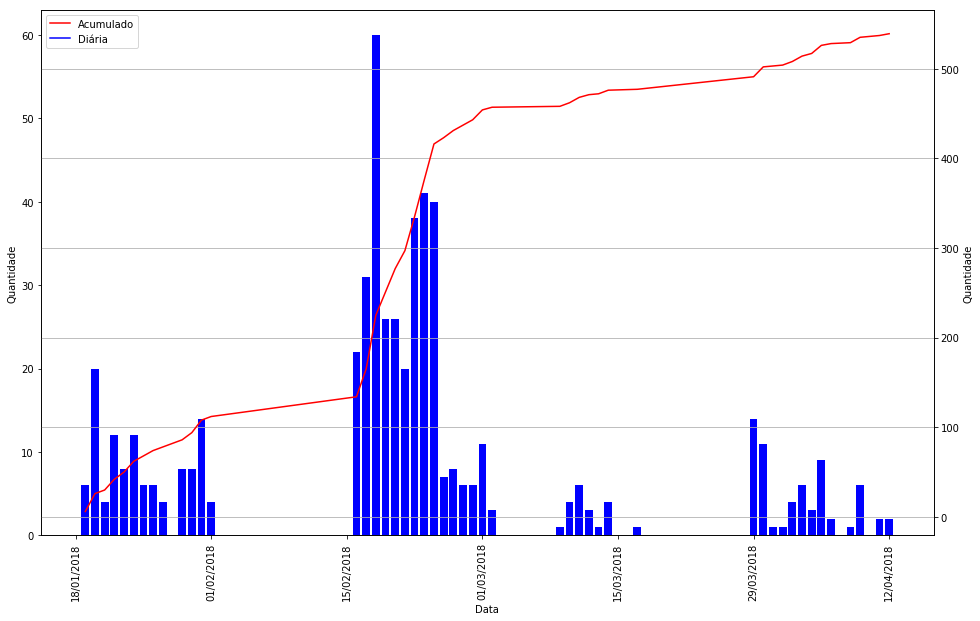

In [8]:
from collections import Counter
import datetime as dt
import matplotlib.dates as mdates

df_ratings['TimeStamp'] = pd.to_datetime(df_ratings['date_creation']).dt.strftime('%m/%d/%Y')
d = Counter(df_ratings['TimeStamp'])
df = pd.DataFrame(list(d.items()), columns=['Date', 'Count'])
df = df.set_index('Date').sort_index()
df.index = pd.to_datetime(df.index)

plt.clf()
fig = plt.figure(figsize=(16, 10))
ax1 = plt.subplot2grid((1,1), (0,0))
ax2 = ax1.twinx()

ax1.bar(df.index, df.Count, color='b')
ax2.plot(df.index, df.Count.cumsum(), color='r', label='Acumulado')
ax2.plot([], [], color='b', label='Diária')
ax1.set_ylabel('Quantidade')
ax2.set_ylabel('Quantidade')
ax1.set_xlabel('Data')

for label in ax1.xaxis.get_ticklabels():
    label.set_rotation(90)

ax1.xaxis.set_major_formatter(mdates.DateFormatter("%d/%m/%Y"))
ax1.xaxis.set_minor_formatter(mdates.DateFormatter("%d/%m/%Y"))

fig.subplots_adjust(bottom=0.15)
ax2.legend(loc='best')

plt.grid(True)
plt.show()



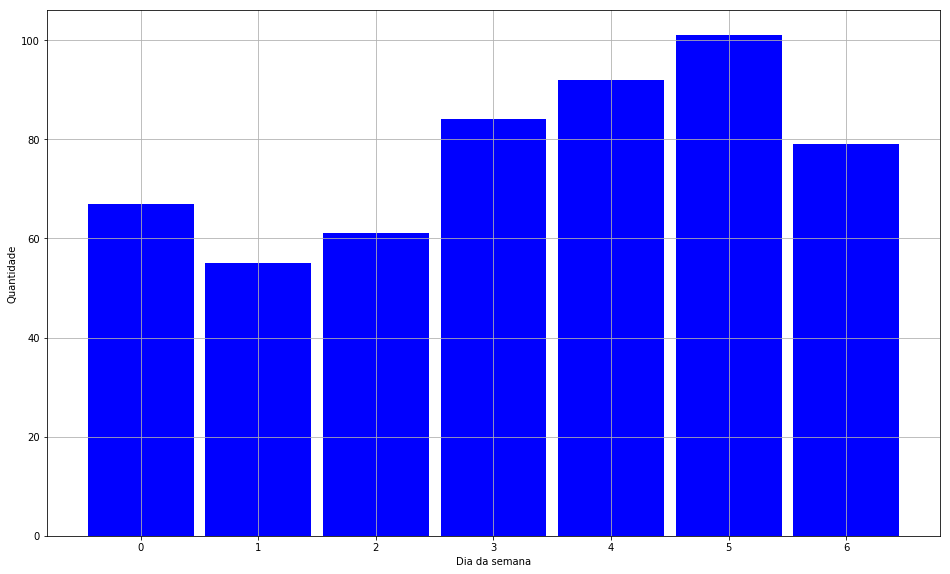

In [9]:
from collections import Counter
import datetime as dt
import matplotlib.dates as mdates

weekdays_keys = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekdays_values = ['Segunda', 'Terça', 'Quarta', 'Quinta', 'Sexta', 'Sábado', 'Domingo']
weekdays_dict = dict(zip(weekdays_keys, weekdays_values))

df_ratings['weekday_name'] = pd.to_datetime(df_ratings['date_creation']).dt.weekday_name
d = Counter(df_ratings['weekday_name'])

df = pd.DataFrame(list(d.items()), columns=['weekday_name', 'count'])
def f(row):
    return weekdays_keys.index(row['weekday_name'])
df['weekday'] = df.apply(f, axis=1)

df['weekday_name'].replace(weekdays_dict, inplace=True)
df = df.set_index('weekday').sort_index()

plt.clf()
fig = plt.figure(figsize=(16, 10))
ax1 = plt.subplot2grid((1,1), (0,0))

ax1.bar(df.index, df['count'], color='b', width=0.9)
ax1.set_ylabel('Quantidade')
ax1.set_xlabel('Dia da semana')

fig.subplots_adjust(bottom=0.15)
ax2.legend(loc='best')

plt.grid(True)
plt.show()

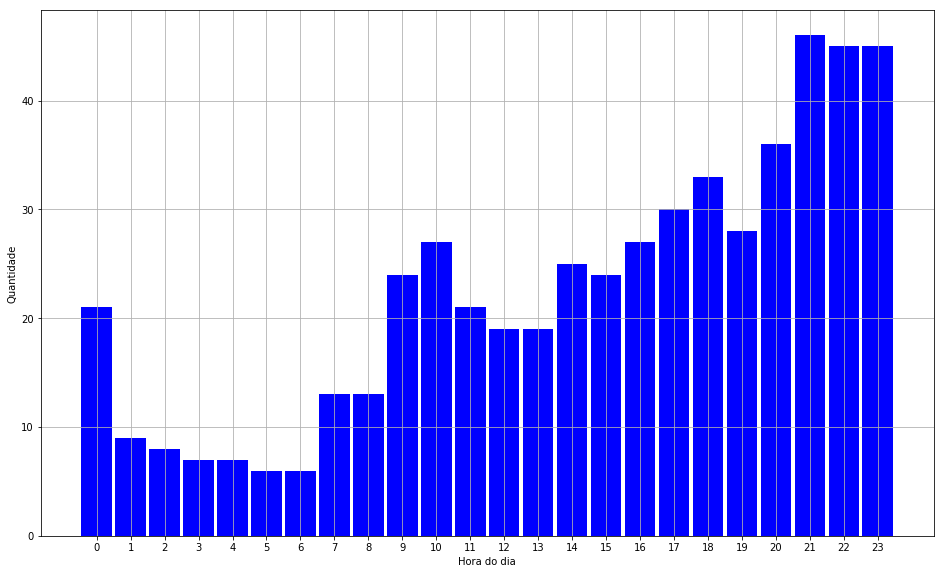

In [10]:
from collections import Counter
import datetime as dt

df_ratings['hour'] = pd.to_datetime(df_ratings['date_creation']).dt.hour
d = Counter(df_ratings['hour'])

df = pd.DataFrame(list(d.items()), columns=['hour', 'count'])

plt.clf()
fig = plt.figure(figsize=(16, 10))
ax1 = plt.subplot2grid((1,1), (0,0))

ax1.bar(df.index, df['count'], color='b', width=0.9)
ax1.set_ylabel('Quantidade')
ax1.set_xlabel('Hora do dia')
ax1.set_xticks(range(len(df.hour)))
ax1.set_xticklabels(df.hour)
fig.subplots_adjust(bottom=0.15)

plt.grid(True)
plt.show()

In [11]:
# df_ratings
df = pd.DataFrame(df_ratings[['watched_type', 'rating_explicit', 'rating_implicit']])
df = pd.get_dummies(df)
# df_corr = df_corr[df_corr.rating_explicit != 0]

injetados_positivos   = df[(df.rating_explicit == 1)     & (df.watched_type_injected == 1)].shape[0]
injetados_negativos   = df[(df.rating_explicit == -1)    & (df.watched_type_injected == 1)].shape[0]
injetados_neutros     = df[(df.rating_explicit == 0)     & (df.watched_type_injected == 1)].shape[0]
injetados_nulos       = df[pd.isnull(df.rating_explicit) & (df.watched_type_injected == 1)].shape[0]
injetados_total       = df[(df.watched_type_injected == 1)].shape[0]
notificados_positivos = df[(df.rating_explicit == 1)     & (df.watched_type_notified == 1)].shape[0]
notificados_negativos = df[(df.rating_explicit == -1)    & (df.watched_type_notified == 1)].shape[0]
notificados_neutros   = df[(df.rating_explicit == 0)     & (df.watched_type_notified == 1)].shape[0]
notificados_nulos     = df[pd.isnull(df.rating_explicit) & (df.watched_type_notified == 1)].shape[0]
notificados_total     = df[(df.watched_type_notified == 1)].shape[0]
print("injetados_positivos:   "+ str(injetados_positivos))
print("injetados_negativos:   "+ str(injetados_negativos))
print("injetados_neutros:     "+ str(injetados_neutros))
print("injetados_nulos:       "+ str(injetados_nulos))
print("injetados_total:       "+ str(injetados_total))
print("notificados_positivos: "+ str(notificados_positivos))
print("notificados_negativos: "+ str(notificados_negativos))
print("notificados_neutros:   "+ str(notificados_neutros))
print("notificados_nulos:     "+ str(notificados_nulos))
print("notificados_total:     "+ str(notificados_total))

# df.dropna(inplace=True)
df = df[(df.rating_explicit == 1) | (df.rating_explicit == -1)]

df_corr1 = df.corr()
df_corr1 = df_corr1.drop(df_corr1.columns[:2], axis=1)
df_corr1 = df_corr1.drop(df_corr1.index[2:], axis=0)
df_corr1


injetados_positivos:   26
injetados_negativos:   13
injetados_neutros:     166
injetados_nulos:       205
injetados_total:       410
notificados_positivos: 36
notificados_negativos: 10
notificados_neutros:   23
notificados_nulos:     60
notificados_total:     129


,watched_type_injected,watched_type_notified
rating_explicit,-0.130045,0.130045
rating_implicit,0.243800,-0.243800


In [12]:
# df_ratings
df = pd.DataFrame(df_ratings[['date_creation', 'rating_explicit', 'rating_implicit']])
df = pd.get_dummies(df)

df['weekday'] = pd.to_datetime(df_ratings['date_creation']).dt.weekday

df['weekend'] = df.apply(lambda row: row.weekday >= 5,axis=1)
df['workingday'] = df.apply(lambda row: row.weekday < 5,axis=1)

weekend_positivos    = df[(df.rating_explicit == 1)     & (df.weekend)].shape[0]
weekend_negativos    = df[(df.rating_explicit == -1)    & (df.weekend)].shape[0]
weekend_neutros      = df[(df.rating_explicit == 0)     & (df.weekend)].shape[0]
weekend_nulos        = df[pd.isnull(df.rating_explicit) & (df.weekend)].shape[0]
weekend_total        = df[(df.weekend)].shape[0]
workingday_positivos = df[(df.rating_explicit == 1)     & (df.workingday)].shape[0]
workingday_negativos = df[(df.rating_explicit == -1)    & (df.workingday)].shape[0]
workingday_neutros   = df[(df.rating_explicit == 0)     & (df.workingday)].shape[0]
workingday_nulos     = df[pd.isnull(df.rating_explicit) & (df.workingday)].shape[0]
workingday_total     = df[(df.workingday)].shape[0]

print("workingday_positivos: "+ str(workingday_positivos))
print("workingday_negativos: "+ str(workingday_negativos))
print("workingday_neutros:   "+ str(workingday_neutros))
print("workingday_nulos:     "+ str(workingday_nulos))
print("workingday_total:     "+ str(workingday_total))
print("weekend_positivos:    "+ str(weekend_positivos))
print("weekend_negativos:    "+ str(weekend_negativos))
print("weekend_neutros:      "+ str(weekend_neutros))
print("weekend_nulos:        "+ str(weekend_nulos))
print("weekend_total:        "+ str(weekend_total))

# df.dropna(inplace=True)
df = df[(df.rating_explicit == 1) | (df.rating_explicit == -1)]

df_corr2 = df.corr()
df_corr2 = df_corr2.drop(df_corr2.columns[:3], axis=1)
df_corr2 = df_corr2.drop(df_corr2.index[2:], axis=0)
df_corr2


workingday_positivos: 51
workingday_negativos: 13
workingday_neutros:   118
workingday_nulos:     177
workingday_total:     359
weekend_positivos:    11
weekend_negativos:    10
weekend_neutros:      71
weekend_nulos:        88
weekend_total:        180


,weekend,workingday
rating_explicit,-0.265098,0.265098
rating_implicit,-0.106565,0.106565


In [13]:
# df_ratings
df = pd.DataFrame(df_ratings[['date_creation', 'rating_explicit', 'rating_implicit']])
df = pd.get_dummies(df)


df['hour'] = pd.to_datetime(df_ratings['date_creation']).dt.hour

df['morning']   = df.apply(lambda row: (row.hour >=  4) & (row.hour < 12), axis=1)
df['afternoon'] = df.apply(lambda row: (row.hour >= 12) & (row.hour < 20), axis=1)
df['evening']   = df.apply(lambda row: (row.hour >= 20) | (row.hour < 4 ),  axis=1)

morning_positivos    = df[(df.rating_explicit == 1)     & (df.morning)].shape[0]
morning_negativos    = df[(df.rating_explicit == -1)    & (df.morning)].shape[0]
morning_neutros      = df[(df.rating_explicit == 0)     & (df.morning)].shape[0]
morning_nulos        = df[pd.isnull(df.rating_explicit) & (df.morning)].shape[0]
morning_total        = df[(df.morning)].shape[0]
afternoon_positivos  = df[(df.rating_explicit == 1)     & (df.afternoon)].shape[0]
afternoon_negativos  = df[(df.rating_explicit == -1)    & (df.afternoon)].shape[0]
afternoon_neutros    = df[(df.rating_explicit == 0)     & (df.afternoon)].shape[0]
afternoon_nulos      = df[pd.isnull(df.rating_explicit) & (df.afternoon)].shape[0]
afternoon_total      = df[(df.afternoon)].shape[0]
evening_positivos    = df[(df.rating_explicit == 1)     & (df.evening)].shape[0]
evening_negativos    = df[(df.rating_explicit == -1)    & (df.evening)].shape[0]
evening_neutros      = df[(df.rating_explicit == 0)     & (df.evening)].shape[0]
evening_nulos        = df[pd.isnull(df.rating_explicit) & (df.evening)].shape[0]
evening_total        = df[(df.evening)].shape[0]
print("morning_positivos:     "+ str(morning_positivos))
print("morning_negativos:     "+ str(morning_negativos))
print("morning_neutros:       "+ str(morning_neutros))
print("morning_nulos:         "+ str(morning_nulos))
print("morning_total:         "+ str(morning_total))
print("afternoon_positivos:   "+ str(afternoon_positivos))
print("afternoon_negativos:   "+ str(afternoon_negativos))
print("afternoon_neutros:     "+ str(afternoon_neutros))
print("afternoon_nulos:       "+ str(afternoon_nulos))
print("afternoon_total:       "+ str(afternoon_total))
print("evening_positivos:     "+ str(evening_positivos))
print("evening_negativos:     "+ str(evening_negativos))
print("evening_neutros:       "+ str(evening_neutros))
print("evening_nulos:         "+ str(evening_nulos))
print("evening_total:         "+ str(evening_total))

# df.dropna(inplace=True)
df = df[(df.rating_explicit == 1) | (df.rating_explicit == -1)]

df_corr3 = df.corr()
df_corr3 = df_corr3.drop(df_corr3.columns[:3], axis=1)
df_corr3 = df_corr3.drop(df_corr3.index[2:], axis=0)
df_corr3

morning_positivos:     8
morning_negativos:     2
morning_neutros:       52
morning_nulos:         55
morning_total:         117
afternoon_positivos:   28
afternoon_negativos:   4
afternoon_neutros:     66
afternoon_nulos:       107
afternoon_total:       205
evening_positivos:     26
evening_negativos:     17
evening_neutros:       71
evening_nulos:         103
evening_total:         217


,morning,afternoon,evening
rating_explicit,0.058018,0.254638,-0.284149
rating_implicit,-0.232492,-0.120771,0.266859


In [14]:
df = pd.DataFrame(df_ratings[['duration', 'rating_explicit', 'rating_implicit']])
df = pd.get_dummies(df)

# Normalize duration column
# from sklearn.preprocessing import MinMaxScaler
# df['duration_scaled'] = MinMaxScaler().fit_transform(df[['duration']].values.astype(float))
# df.dropna(inplace=True)
df = df[(df.rating_explicit == 1) | (df.rating_explicit == -1)]

df_corr4 = df.corr()
df_corr4 = df_corr4.drop(df_corr4.columns[1:], axis=1)
df_corr4 = df_corr4.drop(df_corr4.index[0], axis=0)
df_corr4

,duration
rating_explicit,-0.065689
rating_implicit,-0.022169


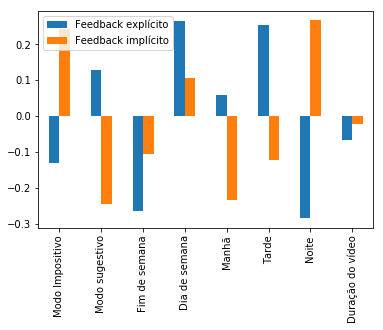

In [15]:
df_corr = pd.concat([df_corr1,df_corr2,df_corr3, df_corr4], axis=1)
columns={'watched_type_injected': 'Modo Impositivo', 
         'watched_type_notified': 'Modo sugestivo',
         'weekend': 'Fim de semana',
         'workingday': 'Dia de semana',
         'morning': 'Manhã',
         'afternoon': 'Tarde',
         'evening': 'Noite',
         'duration': 'Duração do vídeo'
        }
index={'rating_explicit': 'Feedback explícito',
       'rating_implicit': 'Feedback implícito'
        }
df_corr.rename(columns=columns, index=index, inplace=True)
df_corr

plt.clf()
df_corr.T.plot(kind='bar')
plt.show()



In [16]:
df_corr

,Modo Impositivo,Modo sugestivo,Fim de semana,Dia de semana,Manhã,Tarde,Noite,Duração do vídeo
Feedback explícito,-0.130045,0.130045,-0.265098,0.265098,0.058018,0.254638,-0.284149,-0.065689
Feedback implícito,0.243800,-0.243800,-0.106565,0.106565,-0.232492,-0.120771,0.266859,-0.022169



************User ID = 4 name = Teresa Rei
[20  1 31 30 29]


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


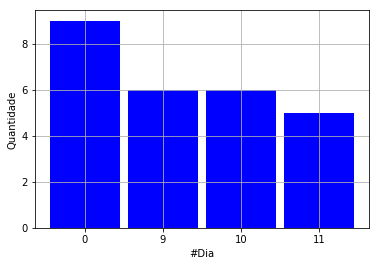


************User ID = 8 name = Pais do Telmo Silva
[22 27  1 28  2]


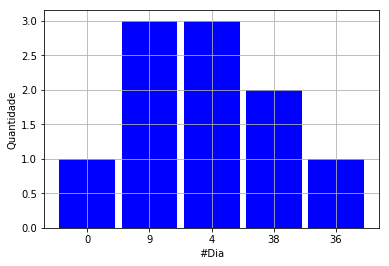


************User ID = 20 name = Helena Gala
[22 23 20 24 25 30 31]


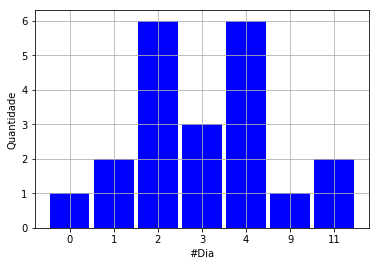


************User ID = 24 name = Daniel Pinto
[19 20 21 22 26 27 29 30]


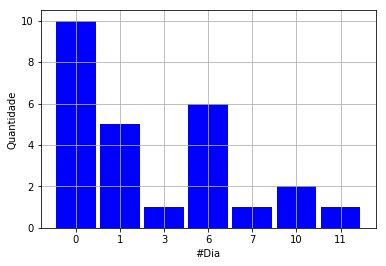


************User ID = 28 name = António Lebre
[23 22 20 21 25 24 29 31]


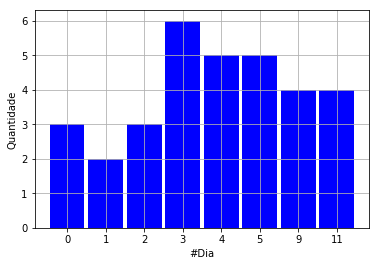


************User ID = 30 name = Manuela + João estragada
[16 17 18]


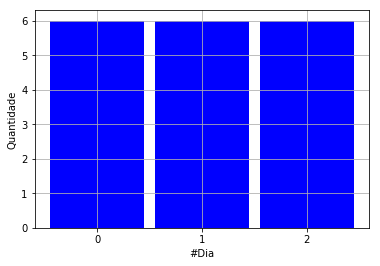


************User ID = 31 name = Rui Silva + Ângela_estragda
[18 16 17 19]


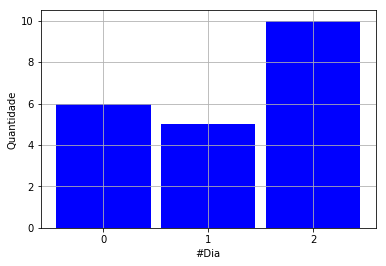


************User ID = 33 name = Adélia-Estragada
[17 19 16 18 21]


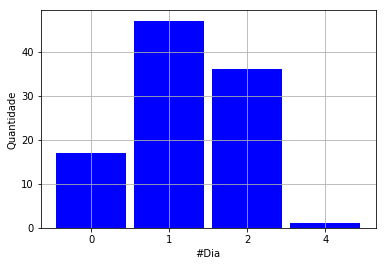


************User ID = 34 name = Manuela+joao Nova
[28 20 23 21 22 26 24 27  1]


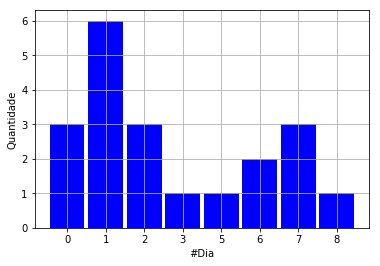


************User ID = 35 name = Rui Silva + Ângela
[21 20 28 23 25 27 24 26  1  2]


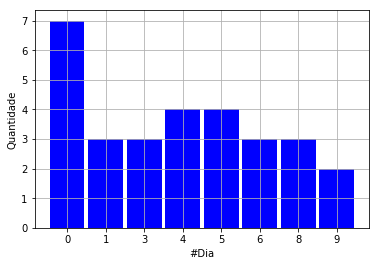


************User ID = 36 name = Manuel Estragada
SEM DADOS
[23 24 22 21 20]


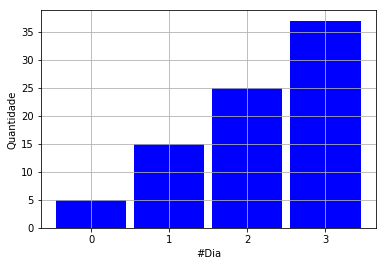


************User ID = 37 name = Adélia
[20 23 22  1 26 21 25 24 27 28  2]


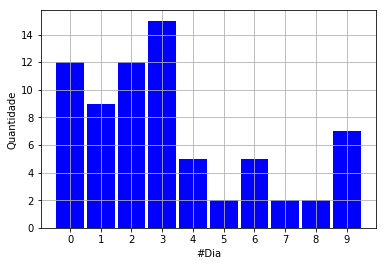


************User ID = 38 name = Lucete Martins
[11 10  9 12 13 14 17]


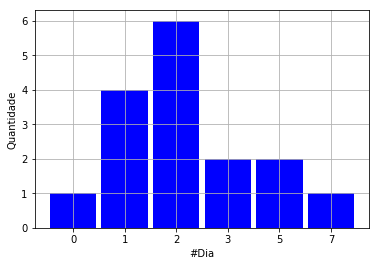


************User ID = 39 name = Teresa Amado
[12 14]


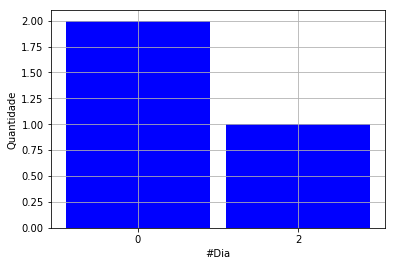


************User ID = 40 name = Lúcia Martins
[14]


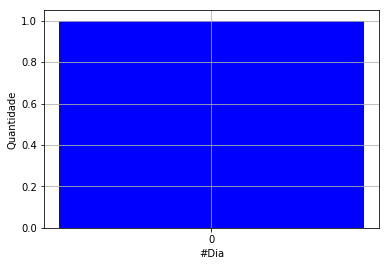


************User ID = 41 name = Otilia
[ 3 30 31  5  6 12 11  9  2  8 29]


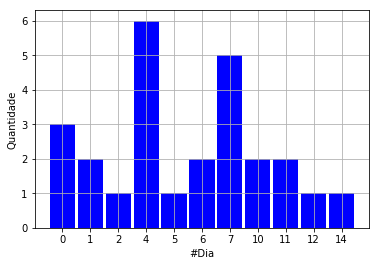


************User ID = 42 name = Alice
[29  2  5  1 30 12 11  9  3  4  6]


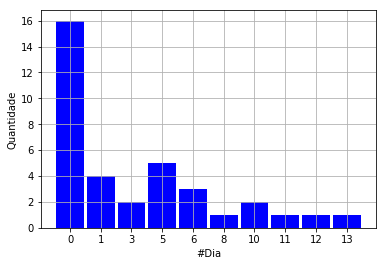

In [17]:

plt.clf()

users = df_ratings.user_id.unique()
for u in users:
    df = df_ratings[(df_ratings.user_id == u)]
    print("\n************User ID = {} name = {}".format(u, df.name.values[0]))
    print(df.date_creation.dt.day.unique())
    df['day_number'] = (df.date_creation - df.date_creation.min()).dt.days

    from collections import Counter

    d = Counter(df['day_number'])

    df = pd.DataFrame(list(d.items()), columns=['day_number', 'count'])
    ax1 = plt.subplot2grid((1,1), (0,0))

    ax1.bar(df.index, df['count'], color='b', width=0.9)
    ax1.set_ylabel('Quantidade')
    ax1.set_xlabel('#Dia')
    ax1.set_xticks(range(len(df.day_number)))
    ax1.set_xticklabels(df.day_number)
    fig.subplots_adjust(bottom=0.15)

    plt.grid(True)
    plt.show()

In [18]:

def handle(df_ratings):
    df = pd.DataFrame(df_ratings[['watched_type', 'rating_explicit', 'rating_implicit']])
    df = pd.get_dummies(df)

    df = df[(df.rating_explicit == 1) | (df.rating_explicit == -1)]

    df_corr1 = df.corr()
    df_corr1 = df_corr1.drop(df_corr1.columns[:2], axis=1)
    df_corr1 = df_corr1.drop(df_corr1.index[2:], axis=0)

    ################################################################################################################

    df = pd.DataFrame(df_ratings[['date_creation', 'rating_explicit', 'rating_implicit']])
    df = pd.get_dummies(df)

    df['weekday'] = pd.to_datetime(df_ratings['date_creation']).dt.weekday

    df['weekend'] = df.apply(lambda row: row.weekday >= 5,axis=1)
    df['workingday'] = df.apply(lambda row: row.weekday < 5,axis=1)

    df_corr2 = df.corr()
    df_corr2 = df_corr2.drop(df_corr2.columns[:3], axis=1)
    df_corr2 = df_corr2.drop(df_corr2.index[2:], axis=0)

    ################################################################################################################

    df = pd.DataFrame(df_ratings[['date_creation', 'rating_explicit', 'rating_implicit']])
    df = pd.get_dummies(df)

    df['hour'] = pd.to_datetime(df_ratings['date_creation']).dt.hour

    df['morning']   = df.apply(lambda row: (row.hour >=  4) & (row.hour < 12), axis=1)
    df['afternoon'] = df.apply(lambda row: (row.hour >= 12) & (row.hour < 20), axis=1)
    df['evening']   = df.apply(lambda row: (row.hour >= 20) | (row.hour < 4 ),  axis=1)

    df.dropna(inplace=True)
    df = df[(df.rating_explicit == 1) | (df.rating_explicit == -1)]

    df_corr3 = df.corr()
    df_corr3 = df_corr3.drop(df_corr3.columns[:3], axis=1)
    df_corr3 = df_corr3.drop(df_corr3.index[2:], axis=0)

    ################################################################################################################
    df = pd.DataFrame(df_ratings[['duration', 'rating_explicit', 'rating_implicit']])
    df = pd.get_dummies(df)

    df = df[(df.rating_explicit == 1) | (df.rating_explicit == -1)]

    df_corr4 = df.corr()
    df_corr4 = df_corr4.drop(df_corr4.columns[1:], axis=1)
    df_corr4 = df_corr4.drop(df_corr4.index[0], axis=0)

    ################################################################################################################
    ################################################################################################################
    ################################################################################################################
    df_corr = pd.concat([df_corr1,df_corr2,df_corr3, df_corr4], axis=1)
    columns={'watched_type_injected': 'Modo Impositivo', 
             'watched_type_notified': 'Modo sugestivo',
             'weekend': 'Fim de semana',
             'workingday': 'Dia de semana',
             'morning': 'Manhã',
             'afternoon': 'Tarde',
             'evening': 'Noite',
             'duration': 'Duração do vídeo'
            }
    index={'rating_explicit': 'Feedback explícito',
           'rating_implicit': 'Feedback implícito'
            }
    df_corr.rename(columns=columns, index=index, inplace=True)

    plt.clf()
    df_corr.T.plot(kind='bar')
    plt.show()
    
    return df_corr




************User ID = 4 name = Teresa Rei
[20  1 31 30 29]


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


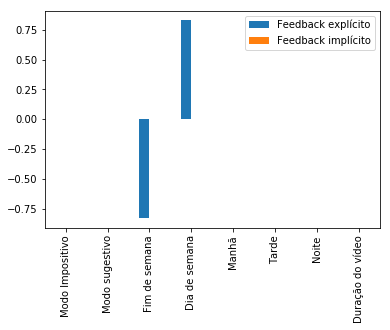


************User ID = 8 name = Pais do Telmo Silva
[22 27  1 28  2]


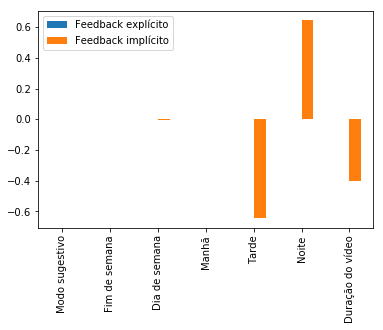


************User ID = 20 name = Helena Gala
[22 23 20 24 25 30 31]


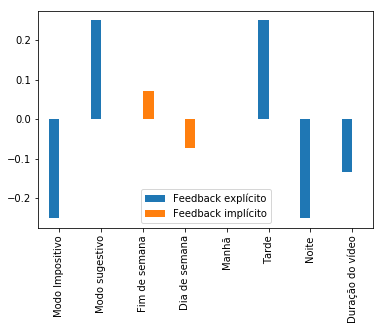


************User ID = 24 name = Daniel Pinto
[19 20 21 22 26 27 29 30]


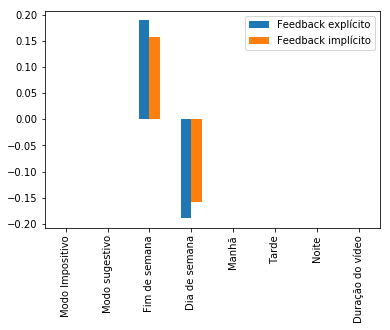


************User ID = 28 name = António Lebre
[23 22 20 21 25 24 29 31]


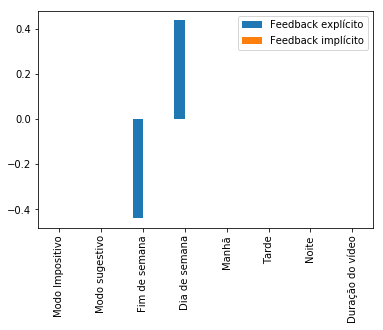


************User ID = 30 name = Manuela + João estragada
[16 17 18]


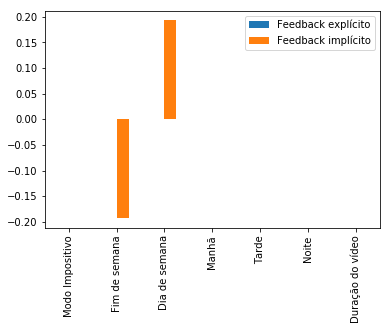


************User ID = 31 name = Rui Silva + Ângela_estragda
[18 16 17 19]


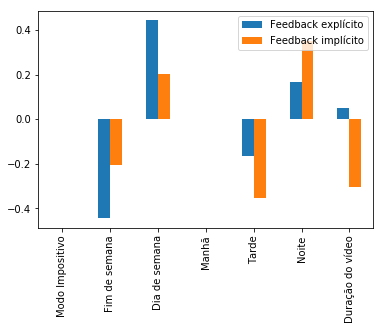


************User ID = 33 name = Adélia-Estragada
[17 19 16 18 21]


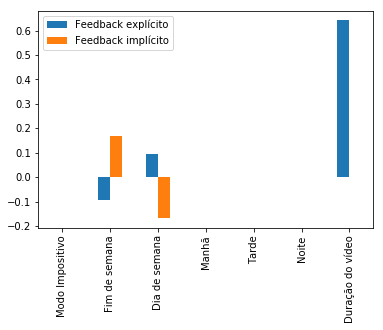


************User ID = 34 name = Manuela+joao Nova
[28 20 23 21 22 26 24 27  1]


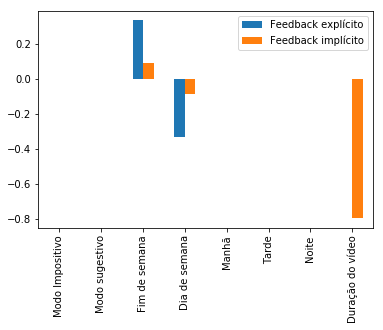


************User ID = 35 name = Rui Silva + Ângela
[21 20 28 23 25 27 24 26  1  2]


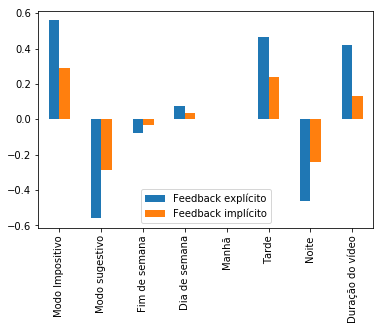


************User ID = 36 name = Manuel Estragada
SEM DADOS
[23 24 22 21 20]


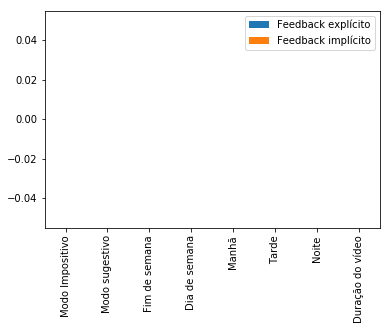


************User ID = 37 name = Adélia
[20 23 22  1 26 21 25 24 27 28  2]


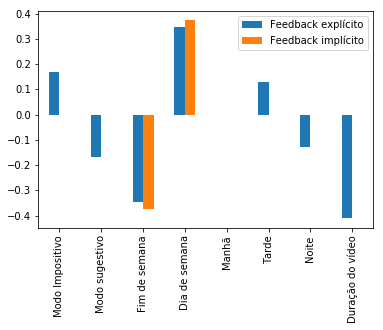


************User ID = 38 name = Lucete Martins
[11 10  9 12 13 14 17]


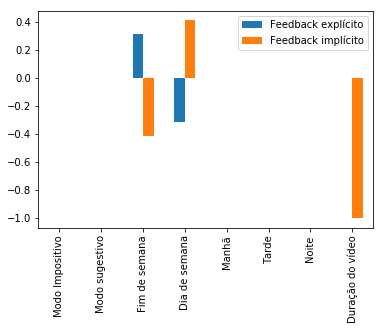


************User ID = 39 name = Teresa Amado
[12 14]


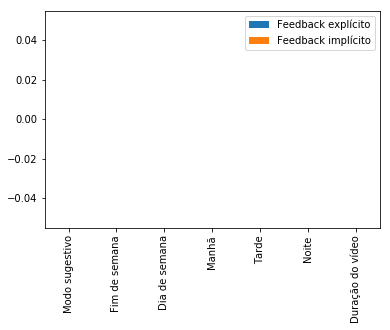


************User ID = 40 name = Lúcia Martins
[14]


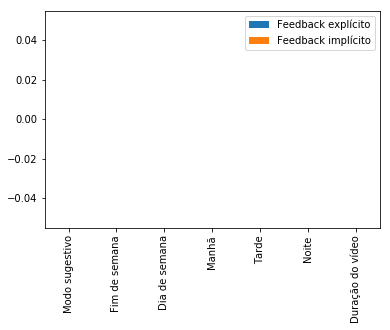


************User ID = 41 name = Otilia
[ 3 30 31  5  6 12 11  9  2  8 29]


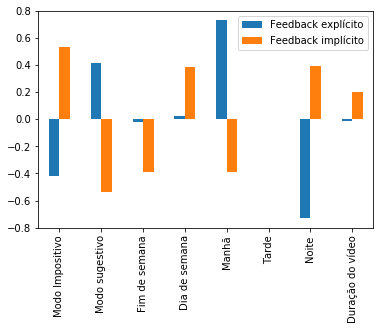


************User ID = 42 name = Alice
[29  2  5  1 30 12 11  9  3  4  6]


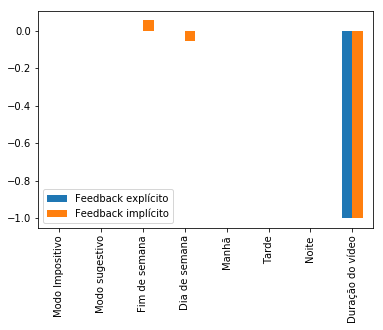

In [19]:
plt.clf()

users = df_ratings.user_id.unique()
for u in users:
    df = df_ratings[(df_ratings.user_id == u)]
    print("\n************User ID = {} name = {}".format(u, df.name.values[0]))
    print(df.date_creation.dt.day.unique())
    df['day_number'] = (df.date_creation - df.date_creation.min()).dt.days

    handle(df)


************User ID = 42 name = Otilia count = 26 
[ 3 30 31  5  6 12 11  9  2  8 29]


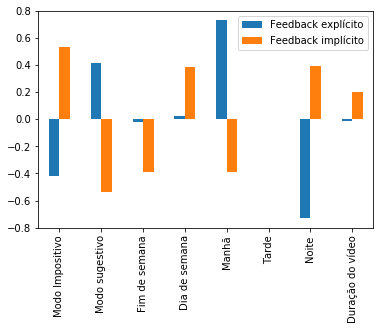

,Modo Impositivo,Modo sugestivo,Fim de semana,Dia de semana,Manhã,Tarde,Noite,Duração do vídeo
Feedback explícito,-0.416667,0.416667,-0.023014,0.023014,0.730297,NaN,-0.730297,-0.011951
Feedback implícito,0.535229,-0.535229,-0.386835,0.386835,-0.390876,NaN,0.390876,0.200575


In [20]:
df = df_ratings[(df_ratings.user_id == 41)]
# df = df_ratings[(df_ratings.user_id == 33) | (df_ratings.user_id == 37)]
print("\n************User ID = {} name = {} count = {} ".format(u, df.name.values[0], df.shape[0]))
print(df.date_creation.dt.day.unique())
df = handle(df)
df

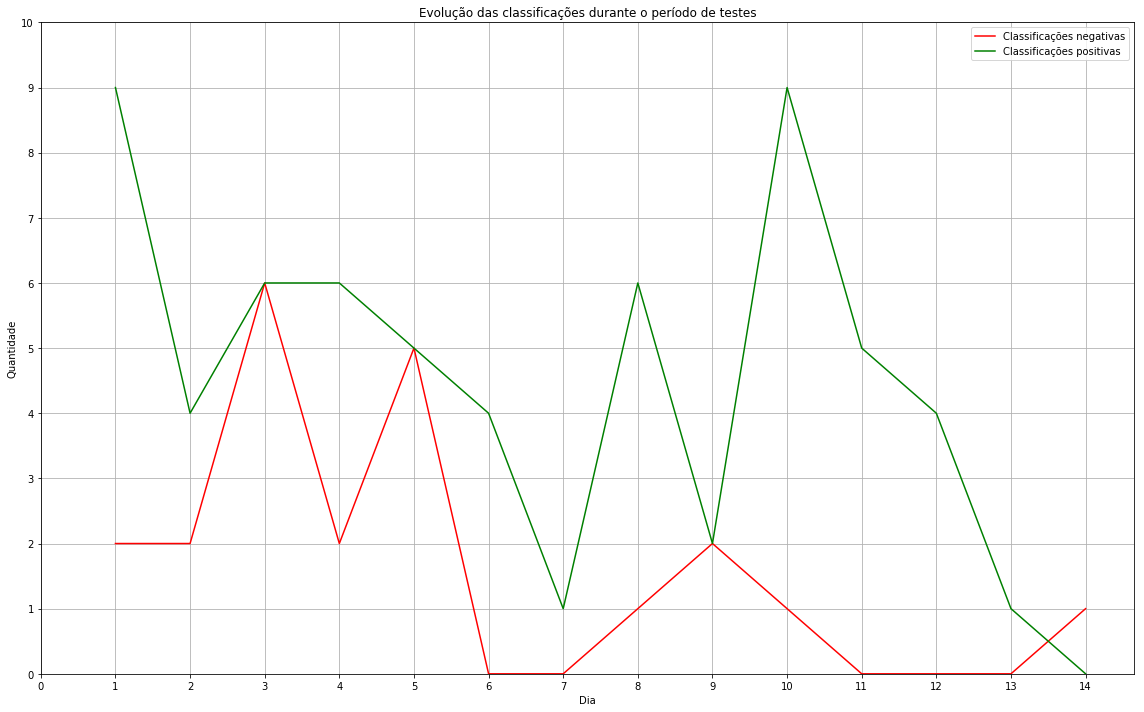

,user_id,name,rating_explicit,rating_implicit,date_creation,delta
id,,,,,,
22558,20,Helena Gala,-1.0,1.00,2 days 01:54:57,3
22649,31,Rui Silva + Ângela_estragda,-1.0,0.03,2 days 07:05:46,3
22655,31,Rui Silva + Ângela_estragda,-1.0,1.00,2 days 05:07:35,3
22666,31,Rui Silva + Ângela_estragda,-1.0,1.00,1 days 11:30:44,2
22695,33,Adélia-Estragada,-1.0,1.00,2 days 06:08:03,3
22697,33,Adélia-Estragada,-1.0,1.00,2 days 03:30:37,3
22712,33,Adélia-Estragada,-1.0,1.00,1 days 03:30:35,2
22796,35,Rui Silva + Ângela,-1.0,1.00,8 days 06:39:45,9
22813,35,Rui Silva + Ângela,-1.0,1.00,4 days 10:46:52,5


In [23]:
# users = df_ratings.user_id.unique()
df = df_ratings[['user_id', 'name', 'rating_explicit', 'rating_implicit', 'date_creation']]
for u in users:
#     print("\n************User ID = {} name = {}".format(u, df[(df.user_id == u)].name.values[0]))
    date_min = df[(df.user_id == u)].date_creation.min()
    def f(row,u):
        if row.user_id == u:
            row.date_creation = row.date_creation - date_min
            
        return row
    
    df = df.apply(lambda row: f(row, u), axis=1)

df['delta'] = pd.to_datetime(df['date_creation']).dt.day

df.dropna(inplace=True)

df1 = df[df.rating_explicit == 1]
d = Counter(df1['delta'])
df1 = pd.DataFrame(list(d.items()), columns=['day', 'count'])


df2 = df[df.rating_explicit == -1]
df3 = df2
d = Counter(df2['delta'])
df2 = pd.DataFrame(list(d.items()), columns=['day', 'count'])
df2 = df2[df2.day <= 14]

for i in range(1,15,1):
        if not i in df1.day.values:
            df1.loc[df1.index.max() + 1] = [i, 0]
        if not i in df2.day.values:
            df2.loc[df2.index.max() + 1] = [i, 0]
df1.sort_values(by=['day'], inplace=True)
df2.sort_values(by=['day'], inplace=True)
            
plt.clf()
fig = plt.figure(figsize=(16, 10))
ax1 = plt.subplot2grid((1,1), (0,0))

plt.title('Evolução das classificações durante o período de testes')
ax1.plot(df2.day, df2['count'], color='r', label='Classificações negativas')
ax1.plot(df1.day, df1['count'], color='g', label='Classificações positivas')

ax1.set_ylabel('Quantidade')
ax1.set_xlabel('Dia')
ax1.set_xticks(range(0,15))
ax1.set_xticklabels(range(0,15))
ax1.set_ylim(1,14)
ax1.set_yticks(range(0,11))
ax1.set_yticklabels(range(0,11))
ax1.set_ylim(0,10)
fig.subplots_adjust(bottom=0.15)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

df3
    
#     print(df.date_creation.dt.day.unique())
#     df['day_number'] = (df.date_creation - df.date_creation.min()).dt.days

#     handle(df)

In [125]:
import numpy as np
dfi = pd.DataFrame(np.arange(6).reshape(3,2), columns=['A','B'])
dfi = dfi.append([0,9])
dfi

,A,B,0
0,0.0,1.0,NaN
1,2.0,3.0,NaN
2,4.0,5.0,NaN
0,NaN,NaN,0.0
1,NaN,NaN,9.0
